# diffusion Terms

    - beta schedule : 각 diffusion 단계에서 추가되는 노이즈는 '베타'라는 매개변수에 의해 제어됨. beta schedule은 모든 단계들에서 사용되는 일련의 beta값들을 의미함

        ㅁ beta schedule은 각 diffusion 단계에서 발생하는 노이즈의 양과 유형을 정의 함.

        ㅁ sigmoid : 시작과 끝의 변화량은 작고 중간 변화량이 큰 함수 모양의 노이즈를 추가

        ㅁ quad, linear(일정한 증가), const(모든 단계에서 고정된, 동일한 베타 값), jsd(모델의 예측과 실제 데이터 간의 차이가 각 단계에서 최소화 되도록 베타 값을 최적화)



In [ ]:
'''
https://github.com/MinkaiXu/GeoDiff/blob/main/configs/qm9_default.yml
geodiff


'''

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install deepchem
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
import sys
import os
import pickle
import copy
import json
from collections import defaultdict
import argparse

import numpy as np
import random

import torch
from torch import nn
import torch.nn.functional as F

import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import Mol, HybridizationType, BondType
from rdkit import RDLogger
import networkx as nx
from tqdm import tqdm

In [4]:
print(f'Python ver. : {sys.version}')
os.environ['TORCH'] = torch.__version__
print(f'Torch ver. : {torch.__version__}')

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git@1.7.2
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

import torch_cluster
import torch_geometric
print(f'torch_geometric ver. : {torch_geometric.__version__}')
from torch_geometric.nn import radius_graph, radius
from torch_geometric.data import Data, Dataset, DataLoader, Batch
from torch_geometric.utils import dropout, to_dense_adj, dense_to_sparse, remove_self_loops, to_networkx
from torch_sparse import coalesce
from torch_scatter import scatter_add, scatter_mean

Python ver. : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Torch ver. : 2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.6 MB/s eta 0:00:00
torch_geometric ver. : 1.7.2


In [5]:
train_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/QM9/train_data_40k.pkl'
val_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/QM9/val_data_5k.pkl'
test_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/QM9/test_data_1k.pkl'

In [6]:
def pr(name, var, show_var=False) :
    print('====')
    try :
        print(f'{name}.shape : {var.shape}')
    except :
        pass
    print(f'{name} : {var}' if show_var else '')
    print('====')
    print()

In [22]:

params = {
    'hidden_dim': 128,
    'num_convs': 6,
    'num_convs_local': 4,
    'cutoff': 10.0,

    'beta_start': 1.e-7,
    'beta_end':  2.e-3,
    'num_diffusion_timesteps':5000,
    'edge_order': 3,
    'edge_encoder': 'mlp',
    'smooth_conv': False,

    'n_steps': 5000,
    'step_lr': 1e-6,
    'w_global': 1.0,
    'global_start_sigma': 0.5,
    'clip': 1000.0,
    'clip_local': None,

    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

parser = argparse.ArgumentParser()

for key, value in params.items():
    parser.add_argument('--' + key, default=value)

args = parser.parse_args('')
print(args)

Namespace(hidden_dim=128, num_convs=6, num_convs_local=4, cutoff=10.0, beta_start=1e-07, beta_end=0.002, num_diffusion_timesteps=5000, edge_order=3, edge_encoder='mlp', smooth_conv=False, n_steps=5000, step_lr=1e-06, w_global=1.0, global_start_sigma=0.5, clip=1000.0, clip_local=None, device=device(type='cuda', index=0))


In [23]:
class ConformationDataset(Dataset):

    def __init__(self, path, transform=None, start=0, end=-1):
        super().__init__()
        with open(path, 'rb') as f:
            self.data = pickle.load(f)
            self.data = self.data[start:end]
        self.transform = transform
        self.atom_types = self._atom_types()
        self.edge_types = self._edge_types()

    def __getitem__(self, idx):

        data = self.data[idx].clone()
        if self.transform is not None:
            data = self.transform(data)
        return data

    def __len__(self):
        return len(self.data)


    def _atom_types(self):
        """All atom types."""
        atom_types = set()
        for graph in self.data:
            atom_types.update(graph.atom_type.tolist())
        return sorted(atom_types)

    def _edge_types(self):
        """All edge types."""
        edge_types = set()
        for graph in self.data:
            edge_types.update(graph.edge_type.tolist())
        return sorted(edge_types)

class CountNodesPerGraph(object):

    def __init__(self) -> None:
        super().__init__()

    def __call__(self, data):
        data.num_nodes_per_graph = torch.LongTensor([data.num_nodes])
        return data

In [10]:
# transforms = CountNodesPerGraph()
# train_set = ConformationDataset(test_dataset_path, transform=transforms, end=64)
# test_set = ConformationDataset(test_dataset_path, transform=transforms, start=64, end=128)

# print(train_set, test_set)

In [11]:
transforms = CountNodesPerGraph()
train_set = ConformationDataset(test_dataset_path, transform=transforms, end=176)

print(train_set)

ConformationDataset(176)


In [ ]:
# mol_list = set()

# for idx, data in enumerate(train_set) :
#     if data.smiles != 'O=CCC#CCCO' :
#         print(idx)
#         break

176


In [12]:
def inf_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [24]:
BOND_TYPES = {t: i for i, t in enumerate(BondType.names.values())}
BOND_NAMES = {i: t for i, t in enumerate(BondType.names.keys())}

print(BOND_TYPES)
print(BOND_NAMES)

{rdkit.Chem.rdchem.BondType.UNSPECIFIED: 0, rdkit.Chem.rdchem.BondType.SINGLE: 1, rdkit.Chem.rdchem.BondType.DOUBLE: 2, rdkit.Chem.rdchem.BondType.TRIPLE: 3, rdkit.Chem.rdchem.BondType.QUADRUPLE: 4, rdkit.Chem.rdchem.BondType.QUINTUPLE: 5, rdkit.Chem.rdchem.BondType.HEXTUPLE: 6, rdkit.Chem.rdchem.BondType.ONEANDAHALF: 7, rdkit.Chem.rdchem.BondType.TWOANDAHALF: 8, rdkit.Chem.rdchem.BondType.THREEANDAHALF: 9, rdkit.Chem.rdchem.BondType.FOURANDAHALF: 10, rdkit.Chem.rdchem.BondType.FIVEANDAHALF: 11, rdkit.Chem.rdchem.BondType.AROMATIC: 12, rdkit.Chem.rdchem.BondType.IONIC: 13, rdkit.Chem.rdchem.BondType.HYDROGEN: 14, rdkit.Chem.rdchem.BondType.THREECENTER: 15, rdkit.Chem.rdchem.BondType.DATIVEONE: 16, rdkit.Chem.rdchem.BondType.DATIVE: 17, rdkit.Chem.rdchem.BondType.DATIVEL: 18, rdkit.Chem.rdchem.BondType.DATIVER: 19, rdkit.Chem.rdchem.BondType.OTHER: 20, rdkit.Chem.rdchem.BondType.ZERO: 21}
{0: 'UNSPECIFIED', 1: 'SINGLE', 2: 'DOUBLE', 3: 'TRIPLE', 4: 'QUADRUPLE', 5: 'QUINTUPLE', 6: 'HEXTU

In [25]:
def extend_graph_order_radius(num_nodes, pos, edge_index, edge_type, batch, order=3, cutoff=10.0,
                              extend_order=True, extend_radius=True):

    # train만 적용
    if extend_order:
        edge_index, edge_type = _extend_graph_order(
            num_nodes=num_nodes,
            edge_index=edge_index,
            edge_type=edge_type, order=order
        )
        # edge_index_order = edge_index
        # edge_type_order = edge_type

    if extend_radius:
        edge_index, edge_type = _extend_to_radius_graph(
            pos=pos,
            edge_index=edge_index,
            edge_type=edge_type,
            cutoff=cutoff,
            batch=batch,
        )

    return edge_index, edge_type

'''
new_edge_index 및 new_edge_type은 직접 연결과 고차 연결을 모두 포함하는 확장된 그래프 표현을 제공합니다.
본질적으로 이 기능은 로컬 연결뿐만 아니라 더 많은 전역 그래프 구조를 캡처하는 데 유용합니다. 이는 원자 간의 간접적인 상호작용이 관련될 수 있는 분자 그래프 처리와 같은 다양한 응용 분야에서 유리할 수 있습니다.

'''

def _extend_graph_order(num_nodes, edge_index, edge_type, order=3):
    """
    Args:
        num_nodes:  Number of atoms.
        edge_index: Bond indices of the original graph.
        edge_type:  Bond types of the original graph.
        order:  Extension order.
    Returns:
        new_edge_index: Extended edge indices.
        new_edge_type:  Extended edge types.
    """

    def binarize(x):
        return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

    def get_higher_order_adj_matrix(adj, order):
        """
        Args:
            adj:        (N, N)
            type_mat:   (N, N)
        Returns:
            Following attributes will be updated:
              - edge_index
              - edge_type
            Following attributes will be added to the data object:
              - bond_edge_index:  Original edge_index.
        """
        adj_mats = [torch.eye(adj.size(0), dtype=torch.long, device=adj.device), \
                    binarize(adj + torch.eye(adj.size(0), dtype=torch.long, device=adj.device))]

        for i in range(2, order+1):
            adj_mats.append(binarize(adj_mats[i-1] @ adj_mats[1]))
        order_mat = torch.zeros_like(adj)

        for i in range(1, order+1):
            order_mat += (adj_mats[i] - adj_mats[i-1]) * i

        return order_mat

    num_types = len(BOND_TYPES)

    N = num_nodes
    # edge_index를 dense representation으로
    adj = to_dense_adj(edge_index).squeeze(0) #(N, N)
    # 연결된 결합 차수 반영
    adj_order = get_higher_order_adj_matrix(adj, order)  # (N, N)
    # edge_index를 결합 종류가 반영된 dense representation으로
    type_mat = to_dense_adj(edge_index, edge_attr=edge_type).squeeze(0)   # (N, N)
    type_highorder = torch.where(adj_order > 1, num_types + adj_order - 1, torch.zeros_like(adj_order))
    assert (type_mat * type_highorder == 0).all()
    type_new = type_mat + type_highorder

    new_edge_index, new_edge_type = dense_to_sparse(type_new)
    _, edge_order = dense_to_sparse(adj_order)

    # data.bond_edge_index = data.edge_index  # Save original edges
    # 잠재적 중복이 제거되고 가장자리 유형이 병합될 수 있는 정규 형식의 그래프입니다.  coalesce 기능을 사용하여 edge 인덱스 및 유형에 중복되거나 불필요한 항목이 없는지 확인합니다.
    new_edge_index, new_edge_type = coalesce(new_edge_index, new_edge_type.long(), N, N) # modify data

    return new_edge_index, new_edge_type


def _extend_to_radius_graph(pos, edge_index, edge_type, cutoff, batch, unspecified_type_number=0):
    '''
    이 함수의 주요 역할은 노드의 공간적 근접성을 기반으로 그래프의 연결성을 향상시키는 것입니다.
    특정 반경(컷오프) 내의 노드는 원래 그래프에 없더라도 서로 연결됩니다.
    이는 특정 거리 내의 원자가 원래 그래프의 가장자리에 포착되지 않은 상호 작용을 가질 수 있는
     분자 그래프와 같이 공간적 근접성이 일종의 관계 또는 상호 작용을 암시하는 시나리오에서 특히 유용합니다.

    '''
    assert edge_type.dim() == 1
    N = pos.size(0)

    # sparse representation
    bgraph_adj = torch.sparse.LongTensor(
        edge_index,
        edge_type,
        torch.Size([N, N])
    ).to(pos.device)

    # 반경(cutoff) 이내의 모든 점(pos)를 edge_index로 표현
    rgraph_edge_index = radius_graph(pos, r=cutoff, batch=batch).to(pos.device)    # (2, E_r)
    # rgraph_edge_index의 sparse representation
    rgraph_adj = torch.sparse.LongTensor(
        rgraph_edge_index,
        torch.ones(rgraph_edge_index.size(1)).long().to(pos.device) * unspecified_type_number,
        torch.Size([N, N])
    )
    composed_adj = (bgraph_adj + rgraph_adj).coalesce()  # Sparse (N, N, T)
    # edge_index = composed_adj.indices()
    # dist = (pos[edge_index[0]] - pos[edge_index[1]]).norm(dim=-1)

    new_edge_index = composed_adj.indices()
    new_edge_type = composed_adj.values().long()

    return new_edge_index, new_edge_type

# 연결된 두 node의 유클리드 거리 계
def get_distance(pos, edge_index):
    return (pos[edge_index[0]] - pos[edge_index[1]]).norm(dim=-1)

def get_sigmoid_beta_schedule(beta_start, beta_end, num_diffusion_timesteps) :
    def sigmoid(x) :
        return 1 / (np.exp(-x)+1)

    betas = np.linspace(-6, 6, num_diffusion_timesteps)
    betas = sigmoid(betas) * ( beta_end - beta_start) + beta_start
    betas = torch.from_numpy(betas).float()

    assert betas.shape == (num_diffusion_timesteps, )
    return betas

# edge로 연결된 node 쌍의 attr을 곱해서, edge_attr과 이어붙임
def assemble_atom_pair_feature(node_attr, edge_index, edge_attr):
    h_row, h_col = node_attr[edge_index[0]], node_attr[edge_index[1]]
    h_pair = torch.cat([h_row*h_col, edge_attr], dim=-1)    # (E, 2H)
    return h_pair

def is_train_edge(edge_index) :
    return torch.ones(edge_index.size(1), device=edge_index.device).bool()

def eq_score(score_dist, pos, edge_index, edge_length):
    # 노드 갯수
    N = pos.size(0)
    # 정규화된 directional derivatives. 두 node의 위치 차이를 edge_length로 나눔(방향 미분)
    dd_dr = (1. / edge_length) * (pos[edge_index[0]] - pos[edge_index[1]])   # (E, 3)
    # node index에 따라 score 분산 합 계산
    score_pos = scatter_add(dd_dr * score_dist, edge_index[0], dim=0, dim_size=N) \
        + scatter_add(- dd_dr * score_dist, edge_index[1], dim=0, dim_size=N) # (N, 3)
    return score_pos

def clip_norm(vec, limit, p=2):
    # 벡터의 유클리드 거리(p=2) 계산
    norm = torch.norm(vec, dim=-1, p=2, keepdim=True)
    # norm이 limit보다 클 경우 항상 limit값을 리턴, limit보다 작거나 같을 경우 vec값을 리턴
    denom = torch.where(norm > limit, limit / norm, torch.ones_like(norm))
    return vec * denom

def center_pos(pos, batch):
    pos_center = pos - scatter_mean(pos, batch, dim=0)[batch]
    return pos_center


In [26]:
class ShiftedSoftplus(torch.nn.Module):
    def __init__(self):
        super(ShiftedSoftplus, self).__init__()
        self.shift = torch.log(torch.tensor(2.0)).item()

    def forward(self, x):
        return F.softplus(x) - self.shift


class CFConv(torch_geometric.nn.MessagePassing):
    def __init__(self, in_channels, out_channels, num_filters, mlp, cutoff, smooth):
        super(CFConv, self).__init__(aggr='add')
        self.lin1 = nn.Linear(in_channels, num_filters, bias=False)
        self.lin2 = nn.Linear(num_filters, out_channels)
        self.mlp = mlp
        self.cutoff = cutoff
        self.smooth = smooth

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        torch.nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0)

    def forward(self, x, edge_index, edge_attr, edge_length):
        if edge_length != None :
            C = (edge_length <= self.cutoff).float()
            W = self.mlp(edge_attr) * C.view(-1, 1)
        else :
            W = self.mlp(edge_attr)

        x = self.lin1(x)
        x = self.propagate(edge_index, x=x, W=W)
        x = self.lin2(x)
        return x

    def message(self, x_j, W):
        return x_j * W


class InteractionBlock(nn.Module):
    def __init__(self, hidden_channels, num_gaussians, num_filters, cutoff, smooth):
        super(InteractionBlock, self).__init__()
        mlp = nn.Sequential(
            nn.Linear(num_gaussians, num_filters),
            ShiftedSoftplus(),
            nn.Linear(num_filters, num_filters),
        )
        self.conv = CFConv(hidden_channels, hidden_channels, num_filters, mlp, cutoff, smooth)
        self.act = ShiftedSoftplus()
        self.lin = nn.Linear(hidden_channels, hidden_channels)

    def forward(self, x, edge_index, edge_attr, edge_length):
        x = self.conv(x, edge_index, edge_attr, edge_length)
        x = self.act(x)
        x = self.lin(x)
        return x


class SchNetEncoder(nn.Module):

    def __init__(self, hidden_channels=128, num_filters=128,
                num_interactions=6, edge_channels=100, cutoff=10.0, smooth=False):
        super().__init__()

        self.hidden_channels = hidden_channels
        self.num_filters = num_filters
        self.num_interactions = num_interactions
        self.cutoff = cutoff

        self.embedding = nn.Embedding(100, hidden_channels, max_norm=10.0)

        self.interactions = nn.ModuleList()
        for _ in range(num_interactions):
            block = InteractionBlock(hidden_channels, edge_channels,
                                     num_filters, cutoff, smooth)
            self.interactions.append(block)

    def forward(self, z, edge_index, edge_attr, edge_length=None, embed_node=True):
        if embed_node:
            assert z.dim() == 1 and z.dtype == torch.long
            h = self.embedding(z)
        else:
            h = z
        for interaction in self.interactions:
            h = h + interaction(h, edge_index, edge_attr, edge_length)

        return h

class MLPEdgeEncoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=100, n_en_layers=3, dropout=0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_en_layers = n_en_layers
        self.bond_emb = nn.Embedding(100, embedding_dim=self.hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList(
            [nn.Linear(
                self.input_dim if i==0 else self.hidden_dim,
                self.hidden_dim) for i in range(self.n_en_layers)
            ])

    @property
    def out_channels(self):
        return self.hidden_dim

    def encode(self, x) :
        for i, layer in enumerate(self.layers, 1) :
            x = layer(x)
            if i != self.n_en_layers :
                x = x.relu()
            x = self.dropout(x)
        return x

    def forward(self, edge_length, edge_type):
        d_emb = self.encode(edge_length) # (num_edge, hidden_dim)
        edge_attr = self.bond_emb(edge_type) # (num_edge, hidden_dim)
        return d_emb * edge_attr # (num_edge, hidden_dim)


class DistMLP(nn.Module):
    def __init__(self, hidden_dims, dropout=0):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList(
            [nn.Linear(
                self.hidden_dims[i-1],
                self.hidden_dims[i]) for i in range(1, len(self.hidden_dims))
            ])

    def forward(self, x) :
        for i, layer in enumerate(self.layers, 1) :
            x = layer(x)
            if i != len(self.layers) :
                x = x.relu()
            x = self.dropout(x)
        return x

In [27]:
class DiffusionModel(nn.Module) :
    def __init__(self, args) :
        super().__init__()
        self.args = args

        self.edge_encoder_global = MLPEdgeEncoder(hidden_dim=args.hidden_dim).to(self.args.device)
        self.edge_encoder_local = MLPEdgeEncoder(hidden_dim=args.hidden_dim).to(self.args.device)

        self.encoder_global = SchNetEncoder(
            hidden_channels=args.hidden_dim,
            num_filters=args.hidden_dim,
            num_interactions=args.num_convs,
            edge_channels=self.edge_encoder_global.out_channels,
            cutoff=args.cutoff,
        )

        self.encoder_local = SchNetEncoder(
            hidden_channels=args.hidden_dim,
            num_filters=args.hidden_dim,
            num_interactions=args.num_convs,
            edge_channels=self.edge_encoder_local.out_channels,
        )

        self.grad_global_dist_mlp = DistMLP(
            [2*args.hidden_dim, args.hidden_dim, args.hidden_dim // 2, 1],
        )

        self.grad_local_dist_mlp = DistMLP(
            [2*args.hidden_dim, args.hidden_dim, args.hidden_dim // 2, 1],
        )

        self.model_global = nn.ModuleList([self.edge_encoder_global, self.encoder_global, self.grad_global_dist_mlp])
        self.model_local = nn.ModuleList([self.edge_encoder_local, self.encoder_local, self.grad_local_dist_mlp])

        # sequence :  0(original data) ~ 4999(pure noise)
        # betas : 각 sequnece에 추가되는 노이즈의 양을 결정하는 noise schedule
        betas = get_sigmoid_beta_schedule(
            beta_start=args.beta_start,
            beta_end=args.beta_end,
            num_diffusion_timesteps=args.num_diffusion_timesteps,
        )
        # alphas : 누적곱. 각 단계에서 original data의 보존된 정도를 나타냄
        alphas = (1. - betas).cumprod(dim=0)

        self.betas = nn.Parameter(betas, requires_grad=False)
        self.alphas = nn.Parameter(alphas, requires_grad=False)
        self.num_timesteps = self.betas.size(0)

    def forward(self, atom_type, pos, bond_index, bond_type, batch, time_step,
                edge_index=None, edge_type=None, edge_length=None, return_edges=False,
                extend_order=True, extend_radius=True) :

        N = atom_type.size(0)
        if edge_index is None or edge_type is None or edge_length is None:
            edge_index, edge_type = extend_graph_order_radius(
                num_nodes=N,
                pos=pos,
                edge_index=bond_index,
                edge_type=bond_type,
                batch=batch,
                order=self.args.edge_order,
                cutoff=self.args.cutoff,
                extend_order=extend_order,
                extend_radius=extend_radius,
            )
            # edge_index로 연결된 pos의 거리
            edge_length = get_distance(pos, edge_index).unsqueeze(-1)   # (E, 1)

        local_edge_mask = edge_type > 0  # (E, )
        sigma_edge = torch.ones(size=(edge_index.size(1), 1), device=pos.device)  # (E, 1)

        edge_attr_global = self.edge_encoder_global(
            edge_length=edge_length,
            edge_type=edge_type
        )

        # Global
        node_attr_global = self.encoder_global(
            z=atom_type,
            edge_index=edge_index,
            edge_length=edge_length,
            edge_attr=edge_attr_global,
        )

        ## Assemble pairwise features
        h_pair_global = assemble_atom_pair_feature(
            node_attr=node_attr_global,
            edge_index=edge_index,
            edge_attr=edge_attr_global,
        )    # (E_global, 2H)

        ## Invariant features of edges (radius graph, global)
        edge_inv_global = self.grad_global_dist_mlp(h_pair_global) * (1.0 / sigma_edge)    # (E_global, 1)

        # Encoding local
        edge_attr_local = self.edge_encoder_local(
            edge_length=edge_length,
            edge_type=edge_type
        )   # Embed edges

        # Local
        node_attr_local = self.encoder_local(
            z=atom_type,
            edge_index=edge_index[:, local_edge_mask],
            edge_attr=edge_attr_local[local_edge_mask],
        )

        ## Assemble pairwise features
        h_pair_local = assemble_atom_pair_feature(
            node_attr=node_attr_local,
            edge_index=edge_index[:, local_edge_mask],
            edge_attr=edge_attr_local[local_edge_mask],
        )    # (E_local, 2H)

        # Invariant features of edges (bond graph, local)
        if isinstance(sigma_edge, torch.Tensor):
            edge_inv_local = self.grad_local_dist_mlp(h_pair_local) * (1.0 / sigma_edge[local_edge_mask]) # (E_local, 1)
        else:
            edge_inv_local = self.grad_local_dist_mlp(h_pair_local) * (1.0 / sigma_edge) # (E_local, 1)

        # train : True, test : False
        if return_edges:
            return edge_inv_global, edge_inv_local, edge_index, edge_type, edge_length, local_edge_mask
        else:
            return edge_inv_global, edge_inv_local


    def get_loss(self, atom_type, pos, bond_index, bond_type, batch,
                 num_nodes_per_graph, num_graphs, anneal_power=2.0,
                 return_unreduced_loss=False, return_unreduced_edge_loss=False,
                 extend_order=True, extend_radius=True):

        N = atom_type.size(0)
        node2graph = batch  # (num_node, )

        # 미러링된 랜덤한 timestep 생성
        time_step = torch.randint(
            0, self.num_timesteps, size=(num_graphs//2+1, ), device=pos.device)
        time_step = torch.cat(
            [time_step, self.num_timesteps-time_step-1], dim=0)[:num_graphs]

        # 랜덤하게 선택된 timestep index에 해당하는 alphas 선택
        a = self.alphas.index_select(0, time_step)
        # 랜덤하게 선택된 timestep index를 pos에 매칭
        a_pos = a.index_select(0, node2graph).unsqueeze(-1)
        # pos shape의 noise 생성
        pos_noise = torch.zeros(size=pos.size(), device=pos.device)
        pos_noise.normal_()

        pos_tilde = pos + pos_noise * (1.0 - a_pos).sqrt() / a_pos.sqrt()

        edge_inv_global, edge_inv_local, edge_index, edge_type, edge_length, local_edge_mask = self(
            atom_type = atom_type,
            pos = pos_tilde,
            bond_index = bond_index,
            bond_type = bond_type,
            batch = batch,
            time_step = time_step,
            return_edges = True,
            extend_order = extend_order,
            extend_radius = extend_radius,
        )   # (E_global, 1), (E_local, 1)

        edge2graph = node2graph.index_select(0, edge_index[0]) # (num_edges, )
        a_edge = a.index_select(0, edge2graph).unsqueeze(-1) # (num_edges, 1)

        dist = get_distance(pos, edge_index).unsqueeze(-1) # (num_edges, 1)
        dist_tilde = edge_length # (num_edges, 1)

        # train_edge_mask = is_train_edge(edge_index)
        # dist_tilde = torch.where(train_edge_mask.unsqueeze(-1), dist_tilde, dist)

        dist_target = (dist - dist_tilde) / (1.0 - a_edge).sqrt() * a_edge.sqrt() #(num_edges, 1)

        ## global loss
        # local_edge_mask가 아닌 것 중 cutoff보다 작은 dist_tilde 값을 취함
        global_mask = torch.logical_and(
            torch.logical_or( dist_tilde <= self.args.cutoff, local_edge_mask.unsqueeze(-1) ),
            ~local_edge_mask.unsqueeze(-1)
        ) # (num_edges, 1)
        # global_mask가 True라면 dist_target의 값, False라면 0
        dist_target_global = torch.where(global_mask, dist_target, torch.zeros_like(dist_target)) # (num_edges, 1)
        # global_mask가 True라면 edge_inv_global, False라면 0
        edge_inv_global = torch.where(global_mask, edge_inv_global, torch.zeros_like(edge_inv_global)) # (num_edges, 1)

        # noise로 pertuated된 차이에 대한 위치 수정 값
        x_score_global = eq_score(dist_target_global, pos_tilde, edge_index, edge_length) # (num_nodes, 3)
        # noise로 pertuated된 차이에 대해 모델이 예측한 위치 수정 값
        pred_score_global = eq_score(edge_inv_global, pos_tilde, edge_index, edge_length) # (num_nodes, 3)

        loss_global = (x_score_global - pred_score_global)**2 # (num_nodes, 3)
        loss_global = 2 * torch.sum(loss_global, dim=-1, keepdim=True) # (num_nodes, 1)

        ## local loss
        # noise로 pertuated된 차이에 대한 위치 수정 값
        x_score_local = eq_score(dist_target[local_edge_mask], pos_tilde, edge_index[:, local_edge_mask], edge_length[local_edge_mask])  # (num_nodes, 3)
        # noise로 pertuated된 차이에 대해 모델이 예측한 위치 수정 값
        pred_score_local = eq_score(edge_inv_local, pos_tilde, edge_index[:, local_edge_mask], edge_length[local_edge_mask]) # (num_nodes, 3)

        loss_local = (x_score_local - pred_score_local)**2 # (num_nodes, 3)
        loss_local = 5 * torch.sum(loss_local, dim=-1, keepdim=True)

        loss = loss_global + loss_local
        return loss_global, loss_local

    def langevin_dynamics_sample(self, atom_type, pos_init, bond_index, bond_type,
                                 batch, num_graphs, extend_order, extend_radius=True,
                                 n_steps=100, step_lr=1e-6, clip=1000, clip_local=None,
                                 clip_pos=None, min_sigma=0, global_start_sigma=float('inf'),
                                 w_global=0.2, w_reg=1.0, **kwargs) :

        def compute_alpha(beta, t) :
            beta = torch.cat( [ torch.zeros(1).to(beta.device), beta ], dim=0 )
            a = (1 - beta).cumprod(dim=0).index_select(0, t+1)

            return a

        # sigmas : noise가 추가된 정도. 값이 클수록 noise가 많다는걸 의미
        sigmas = (1.0 - self.alphas).sqrt() / self.alphas.sqrt() # (num_timesteps, )
        self.sigmas = sigmas
        pos_traj = []

        with torch.no_grad() :
            seq = range(self.num_timesteps - n_steps, self.num_timesteps)
            seq_next = [-1] + list(seq[:-1])

            pos = pos_init * sigmas[-1]
            # reverse diffusion process : noise로부터 sequential하게 molecule을 복원
            # seq(i): 4999, 4998, ... 0
            # seq_next(j): 4998, 4997, ... -1
            for i, j in tqdm(zip(reversed(seq), reversed(seq_next)), desc='sample') :
                t = torch.full(size=(num_graphs,), fill_value=i, dtype=torch.long, device=pos.device) # (batch_size,)

                edge_inv_global, edge_inv_local, edge_index, edge_type, edge_length, local_edge_mask = self(
                    atom_type=atom_type,
                    pos=pos,
                    bond_index=bond_index,
                    bond_type=bond_type,
                    batch=batch,
                    time_step=t,
                    return_edges=True,
                    extend_order=extend_order,
                    extend_radius=extend_radius,
                ) # (E_global, 1), (E_local, 1)

                # global
                # noise의 정도(sigmas[i])가 임계점(global_start_sigma)보다 작을 때부터 시작
                if sigmas[i] < global_start_sigma :
                    edge_inv_global = edge_inv_global * (1-local_edge_mask.view(-1, 1).float())
                    pred_score_global = eq_score(edge_inv_global, pos, edge_index, edge_length) # (num_nodes, 3)
                    pred_score_global = clip_norm(pred_score_global, limit=clip)
                else :
                    pred_score_global = 0

                # local
                pred_score_local = eq_score(edge_inv_local, pos, edge_index[:, local_edge_mask], edge_length[local_edge_mask])
                eps_pos = pred_score_local + pred_score_global * w_global

                ## sampling
                noise = torch.randn_like(pos) #(num_nodes, 3)
                b = self.betas
                t = t[0]
                next_t = (torch.ones(1) * j).to(pos.device)

                # at_next > at
                at = compute_alpha(b, t.long())
                at_next = compute_alpha(b, next_t.long())
                beta_t = 1 - at / at_next
                # e : 모델로 예측된 noise를 제거하는 pos 변화량
                e = -eps_pos # (num_nodes, 3)
                # 시간 단계 t에 대해 더해졌던 noise를 제거한 pos
                pos0_from_e = (1.0 / at).sqrt() * pos - (1.0 / at - 1).sqrt() * e #(num_nodes, 3)
                # 다음 단계의 평균 예상 위치(잡음이 제거된 후의 위치 + 현재 위치)
                # at, beta 등은 노이즈의 영향을 받을 것으로 예상되는 정도를 조정하는 역할
                mean = (
                    (at_next.sqrt() * beta_t) * pos0_from_e +
                    ((1-beta_t).sqrt() * (1-at_next))*pos
                ) / (1.0 - at) # (num_nodes, 3)
                mask = 1 - (t==0).float()
                logvar = beta_t.log()
                pos_next = mean + mask * torch.exp(0.5 * logvar) * noise
                pos = pos_next

                if torch.isnan(pos).any() :
                    print('NaN detected. Please restart.')
                    raise FloatingPointError()
                pos = center_pos(pos, batch)
                pos_traj.append(pos.clone().cpu())

        return pos, pos_traj

In [28]:
batch_size = 64
tt_iter = DataLoader(train_set, batch_size, shuffle=True)

model = DiffusionModel(args).to(args.device)
optimizer_global = torch.optim.Adam(model.model_global.parameters(), lr=5.e-4, betas=(0.95, 0.999))
optimizer_local = torch.optim.Adam(model.model_local.parameters(), lr=5.e-4, betas=(0.95, 0.999))

O=CCC#CCCO


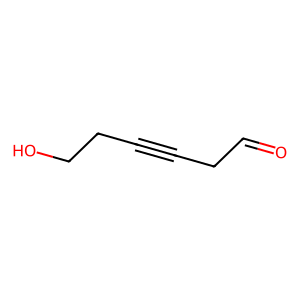

O=CCC#CCCO


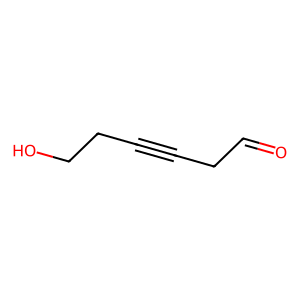

O=CCC#CCCO


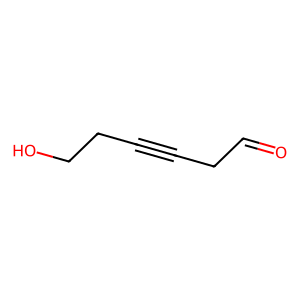

In [ ]:
# from PIL import Image
# from IPython.core.display import display

for idx, data in enumerate(tt_iter) :
    model.train()
    data = data.to(args.device)
    print(data.smiles[0])
    mol = Chem.MolFromSmiles(data.smiles[0])
    img = rdkit.Chem.Draw.MolToImage(mol, kekulize=False)
    display(img)

In [ ]:
### train
for i in tqdm(range(3000)) :
    sum_loss = 0
    for idx, data in enumerate(tt_iter) :
        model.train()
        data = data.to(args.device)
        optimizer_global.zero_grad()
        optimizer_local.zero_grad()

        atom_type = data.atom_type
        pos = data.pos
        num_nodes = data.pos.size(0)
        batch = data.batch
        edge_index = data.edge_index
        edge_type = data.edge_type
        smiles = data.smiles
        num_nodes_per_graph=data.num_nodes_per_graph
        num_graphs=data.num_graphs

        loss_global, loss_local = model.get_loss(atom_type=atom_type,
                    pos=pos,
                    bond_index=edge_index,
                    bond_type=edge_type,
                    batch=batch,
                    num_nodes_per_graph=num_nodes_per_graph,
                    num_graphs=num_graphs,
                    return_unreduced_loss=True)


        loss_global = loss_global.mean()
        loss_local = loss_local.mean()

        torch.autograd.set_detect_anomaly(True)

        loss_global.backward()
        loss_local.backward()

        optimizer_global.step()
        optimizer_local.step()

        loss = loss_global + loss_local
        sum_loss += loss.sum().item()

    avg_loss = sum_loss / len(tt_iter)
    if i % 50 == 0 :
        print(f'{i} : {avg_loss:.4f}')


  0%|          | 0/3000 [00:00<?, ?it/s]<ipython-input-13-501414d7ce98>:105: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  bgraph_adj = torch.sparse.LongTensor(
  0%|          | 1/3000 [00:04<3:21:54,  4.04s/it]

0 : 1461.8582


  2%|▏         | 51/3000 [00:36<32:29,  1.51it/s]

50 : 707.2736


  3%|▎         | 101/3000 [01:10<31:28,  1.53it/s]

100 : 570.9651


  5%|▌         | 151/3000 [01:42<31:10,  1.52it/s]

150 : 475.4471


  7%|▋         | 201/3000 [02:16<30:38,  1.52it/s]

200 : 446.2633


  8%|▊         | 251/3000 [02:48<29:36,  1.55it/s]

250 : 401.4008


 10%|█         | 301/3000 [03:21<30:27,  1.48it/s]

300 : 368.8073


 12%|█▏        | 351/3000 [03:54<28:47,  1.53it/s]

350 : 336.6014


 13%|█▎        | 401/3000 [04:28<28:29,  1.52it/s]

400 : 314.8709


 15%|█▌        | 451/3000 [05:01<30:46,  1.38it/s]

450 : 288.8378


 17%|█▋        | 501/3000 [05:34<27:04,  1.54it/s]

500 : 267.0209


 18%|█▊        | 551/3000 [06:07<27:32,  1.48it/s]

550 : 250.8961


 20%|██        | 601/3000 [06:40<25:36,  1.56it/s]

600 : 258.5214


 22%|██▏       | 651/3000 [07:13<25:36,  1.53it/s]

650 : 239.2320


 23%|██▎       | 701/3000 [07:46<25:12,  1.52it/s]

700 : 241.3680


 25%|██▌       | 751/3000 [08:19<24:28,  1.53it/s]

750 : 220.4357


 27%|██▋       | 801/3000 [08:52<26:50,  1.37it/s]

800 : 230.7833


 28%|██▊       | 851/3000 [09:25<23:27,  1.53it/s]

850 : 206.4721


 30%|███       | 901/3000 [09:58<23:07,  1.51it/s]

900 : 216.5819


 32%|███▏      | 951/3000 [10:31<22:01,  1.55it/s]

950 : 204.8120


 33%|███▎      | 1001/3000 [11:04<21:44,  1.53it/s]

1000 : 262.6458


 35%|███▌      | 1051/3000 [11:37<21:07,  1.54it/s]

1050 : 187.3855


 37%|███▋      | 1101/3000 [12:10<20:24,  1.55it/s]

1100 : 211.1021


 38%|███▊      | 1151/3000 [12:43<20:38,  1.49it/s]

1150 : 168.5160


 40%|████      | 1201/3000 [13:16<19:41,  1.52it/s]

1200 : 178.7492


 42%|████▏     | 1251/3000 [13:49<19:25,  1.50it/s]

1250 : 179.9396


 43%|████▎     | 1301/3000 [14:22<18:21,  1.54it/s]

1300 : 192.7657


 45%|████▌     | 1351/3000 [14:55<17:50,  1.54it/s]

1350 : 185.2381


 47%|████▋     | 1401/3000 [15:28<17:05,  1.56it/s]

1400 : 172.0602


 48%|████▊     | 1451/3000 [16:01<16:58,  1.52it/s]

1450 : 180.6934


 48%|████▊     | 1453/3000 [16:03<17:05,  1.51it/s]


KeyboardInterrupt: ignored

In [ ]:
# ckpt_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/diffusion_tutorial.pth'

# torch.save({
#         'config': args,
#         'model': model.state_dict(),
#         'optimizer_global': optimizer_global.state_dict(),
#         'optimizer_local': optimizer_local.state_dict(),
#         'iteration': i,
#         'avg_val_loss': loss,
#     }, ckpt_path)


In [31]:
ckpt['model'].keys()

odict_keys(['betas', 'alphas', 'edge_encoder_global.bond_emb.weight', 'edge_encoder_global.mlp.layers.0.weight', 'edge_encoder_global.mlp.layers.0.bias', 'edge_encoder_global.mlp.layers.1.weight', 'edge_encoder_global.mlp.layers.1.bias', 'edge_encoder_local.bond_emb.weight', 'edge_encoder_local.mlp.layers.0.weight', 'edge_encoder_local.mlp.layers.0.bias', 'edge_encoder_local.mlp.layers.1.weight', 'edge_encoder_local.mlp.layers.1.bias', 'encoder_global.embedding.weight', 'encoder_global.interactions.0.conv.lin1.weight', 'encoder_global.interactions.0.conv.lin2.weight', 'encoder_global.interactions.0.conv.lin2.bias', 'encoder_global.interactions.0.conv.nn.0.weight', 'encoder_global.interactions.0.conv.nn.0.bias', 'encoder_global.interactions.0.conv.nn.2.weight', 'encoder_global.interactions.0.conv.nn.2.bias', 'encoder_global.interactions.0.lin.weight', 'encoder_global.interactions.0.lin.bias', 'encoder_global.interactions.1.conv.lin1.weight', 'encoder_global.interactions.1.conv.lin2.weig

In [29]:
# ckpt_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/diffusion_tutorial.pth'
ckpt_path = 'qm9_default.pt'

ckpt = torch.load(ckpt_path, map_location=args.device)
print(ckpt.keys())

model = DiffusionModel(args).to(args.device)
optimizer_global = torch.optim.Adam(model.model_global.parameters(), lr=1.e-3, betas=(0.95, 0.999))
optimizer_local = torch.optim.Adam(model.model_local.parameters(), lr=1.e-3, betas=(0.95, 0.999))

model.load_state_dict(ckpt['model'])
optimizer_global.load_state_dict(ckpt['optimizer_global'])
optimizer_local.load_state_dict(ckpt['optimizer_local'])

dict_keys(['config', 'model', 'optimizer_global', 'scheduler_global', 'optimizer_local', 'scheduler_local', 'iteration', 'avg_val_loss'])


RuntimeError: ignored

In [ ]:
### test

done_smiles = set()
results=[]

for idx, data in enumerate(tt_iter) :

    data_input = data.clone()
    data_input['pos_ref'] = None

    model.eval()
    data = data.to(args.device)
    pos_init = torch.randn(data.num_nodes, 3).to(args.device)
    pos_gen, pos_traj = model.langevin_dynamics_sample(
                atom_type=data.atom_type,
                pos_init=pos_init,
                bond_index=data.edge_index,
                bond_type=data.edge_type,
                batch=data.batch,
                num_graphs=data.num_graphs,
                extend_order=False,
                n_steps=args.n_steps,
                step_lr=1e-6,
                w_global=args.w_global,
                global_start_sigma=args.global_start_sigma,
                clip=args.clip,
                clip_local=args.clip_local
    )

    pr('real_pos', data.pos, show_var=True)
    pr('pos_gen', pos_gen, show_var=True)
    pr('pos_traj', pos_traj[-1], show_var=True)

    pos_gen = pos_gen.cpu()
    data_input['pos_gen'] = pos_gen
    results.append(data_input)

sample: 2000it [00:28, 70.09it/s]


====
real_pos.shape : torch.Size([1024, 3])
real_pos : tensor([[-3.1461,  0.8143,  0.1013],
        [-3.7465,  1.1711,  0.7627],
        [-2.7087, -0.4639,  0.5084],
        ...,
        [-2.4235,  1.8482, -0.4553],
        [-2.0685, -0.3761, -1.4939],
        [-3.4552, -0.4283, -0.3762]], device='cuda:0')
====

====
pos_gen.shape : torch.Size([1024, 3])
pos_gen : tensor([[-0.0221,  0.0152, -0.0324],
        [-0.0204,  0.0191, -0.0326],
        [ 0.6421,  0.0542, -0.2425],
        ...,
        [-4.5297,  6.3592, -1.2561],
        [-1.7890,  3.4081, -3.0236],
        [-0.9694,  3.1194, -3.7109]], device='cuda:0')
====

====
pos_traj.shape : torch.Size([1024, 3])
pos_traj : tensor([[-0.0221,  0.0152, -0.0324],
        [-0.0204,  0.0191, -0.0326],
        [ 0.6421,  0.0542, -0.2425],
        ...,
        [-4.5297,  6.3592, -1.2561],
        [-1.7890,  3.4081, -3.0236],
        [-0.9694,  3.1194, -3.7109]])
====



sample: 2000it [00:28, 69.81it/s]


====
real_pos.shape : torch.Size([1024, 3])
real_pos : tensor([[-3.1027, -0.9480,  0.4531],
        [-3.7521, -1.5558,  0.0870],
        [-3.0050,  0.1882, -0.3764],
        ...,
        [-2.0529,  0.6111, -1.5970],
        [-4.0121,  0.4310,  0.0162],
        [-2.8203,  0.2191,  1.3290]], device='cuda:0')
====

====
pos_gen.shape : torch.Size([1024, 3])
pos_gen : tensor([[ 5.5956, -5.6331,  5.9602],
        [ 5.5757, -6.3920,  5.4228],
        [ 4.5234, -1.9463,  5.2018],
        ...,
        [-4.6314,  4.1530, -2.6759],
        [ 2.2911,  6.2840, -1.2345],
        [ 4.3512,  4.7356,  1.6424]], device='cuda:0')
====

====
pos_traj.shape : torch.Size([1024, 3])
pos_traj : tensor([[ 5.5956, -5.6331,  5.9602],
        [ 5.5757, -6.3920,  5.4228],
        [ 4.5234, -1.9463,  5.2018],
        ...,
        [-4.6314,  4.1530, -2.6759],
        [ 2.2911,  6.2840, -1.2345],
        [ 4.3512,  4.7356,  1.6424]])
====



sample: 1224it [00:16, 73.63it/s]


KeyboardInterrupt: ignored

In [ ]:
results

[Batch(atom_type=[1024], batch=[1024], boltzmannweight=[64], edge_index=[2, 1920], edge_type=[1920], idx=[64], num_nodes_per_graph=[64], nx=[64], pos=[1024, 3], pos_gen=[1024, 3], ptr=[65], rdmol=[64], smiles=[64], totalenergy=[64]),
 Batch(atom_type=[1024], batch=[1024], boltzmannweight=[64], edge_index=[2, 1920], edge_type=[1920], idx=[64], num_nodes_per_graph=[64], nx=[64], pos=[1024, 3], pos_gen=[1024, 3], ptr=[65], rdmol=[64], smiles=[64], totalenergy=[64])]

In [ ]:
test_pos_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/test_pos.pth'

torch.save({
        'results': results,
    }, test_pos_path)

In [18]:
test_pos_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/test_pos.pth'
results = torch.load(test_pos_path, map_location=args.device)
print(results.keys())
data = results['results'][0]
print(data)

dict_keys(['results'])
Batch(atom_type=[1024], batch=[1024], boltzmannweight=[64], edge_index=[2, 1920], edge_type=[1920], idx=[64], num_nodes_per_graph=[64], nx=[64], pos=[1024, 3], pos_gen=[1024, 3], ptr=[65], rdmol=[64], smiles=[64], totalenergy=[64])


O=CCC#CCCO


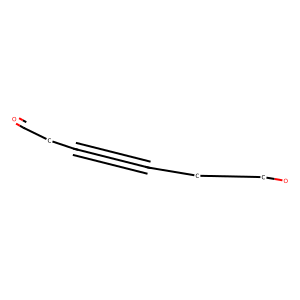

O=CCC#CCCO


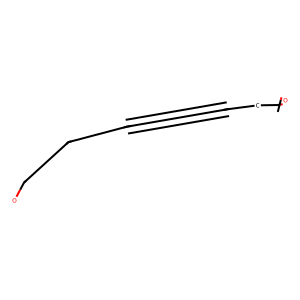

O=CCC#CCCO


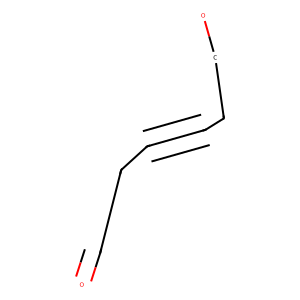

O=CCC#CCCO


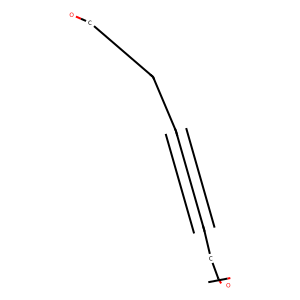

O=CCC#CCCO


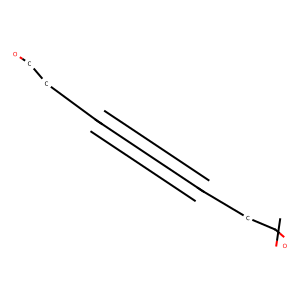

O=CCC#CCCO


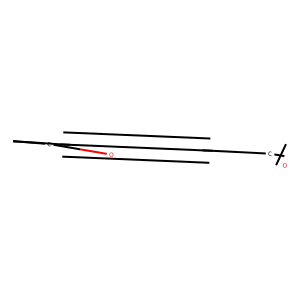

O=CCC#CCCO


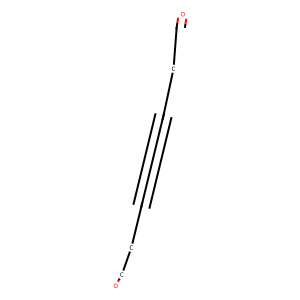

O=CCC#CCCO


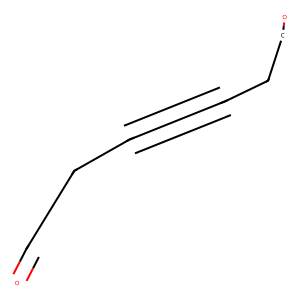

O=CCC#CCCO


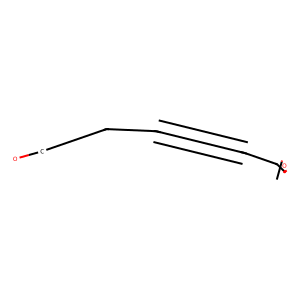

O=CCC#CCCO


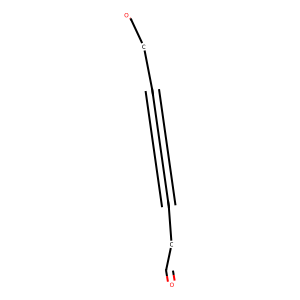

O=CCC#CCCO


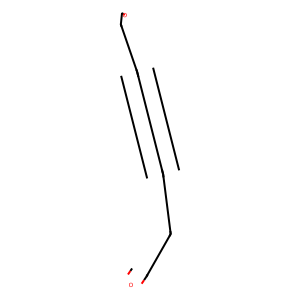

O=CCC#CCCO


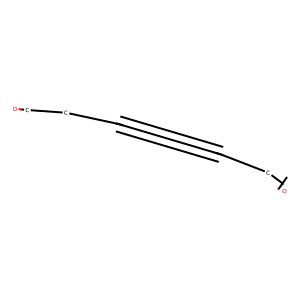

O=CCC#CCCO


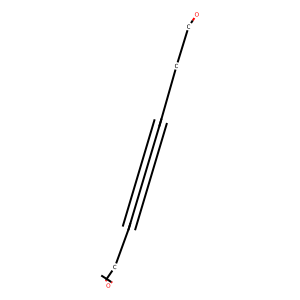

O=CCC#CCCO


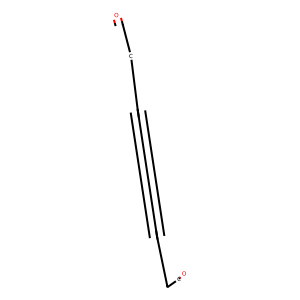

O=CCC#CCCO


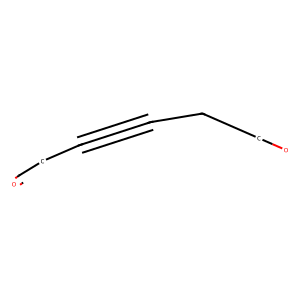

O=CCC#CCCO


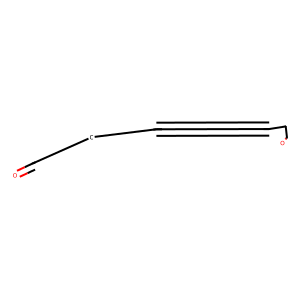

O=CCC#CCCO


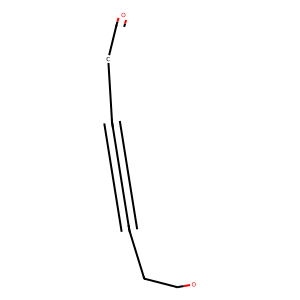

O=CCC#CCCO


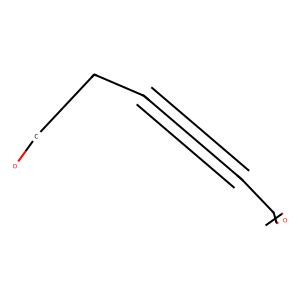

O=CCC#CCCO


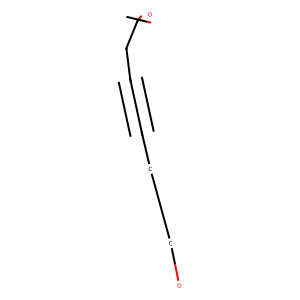

O=CCC#CCCO


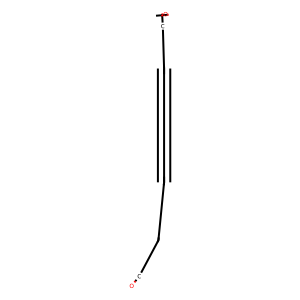

O=CCC#CCCO


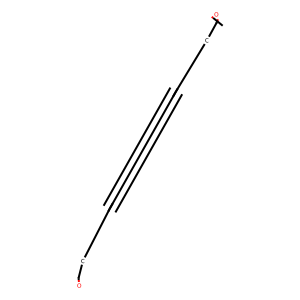

O=CCC#CCCO


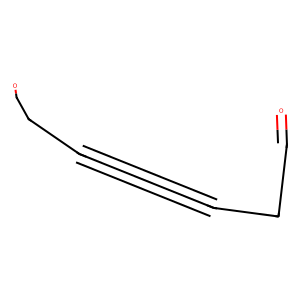

O=CCC#CCCO


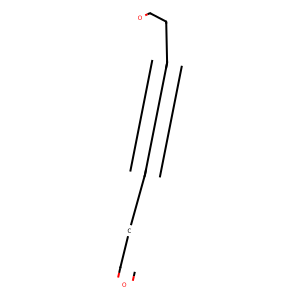

O=CCC#CCCO


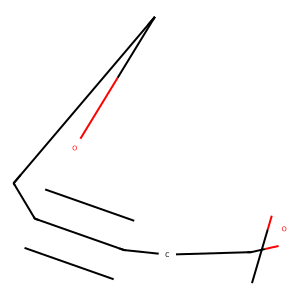

O=CCC#CCCO


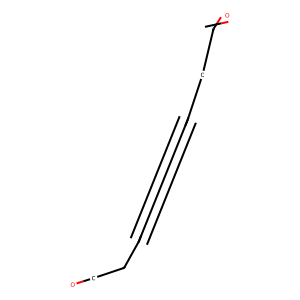

O=CCC#CCCO


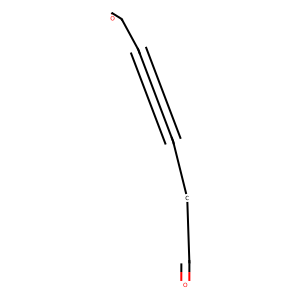

O=CCC#CCCO


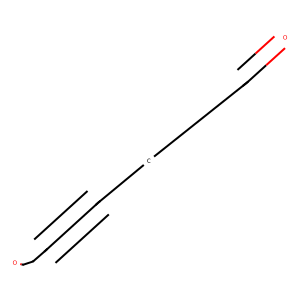

O=CCC#CCCO


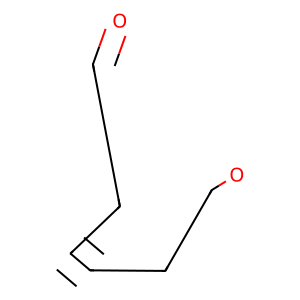

O=CCC#CCCO


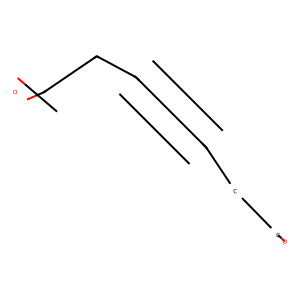

O=CCC#CCCO


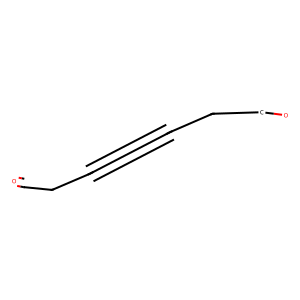

O=CCC#CCCO


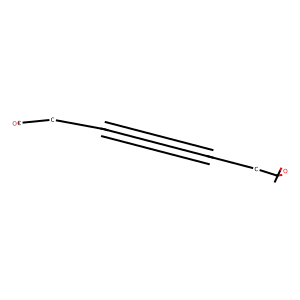

O=CCC#CCCO


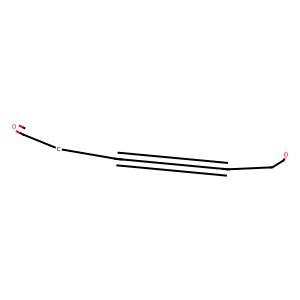

O=CCC#CCCO


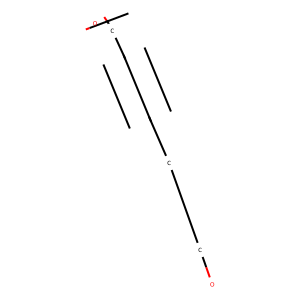

O=CCC#CCCO


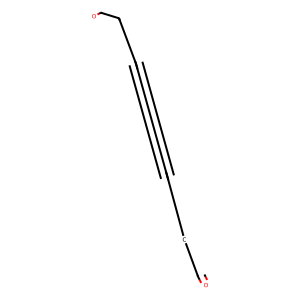

O=CCC#CCCO


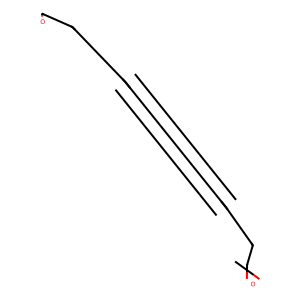

O=CCC#CCCO


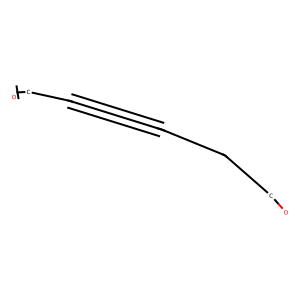

O=CCC#CCCO


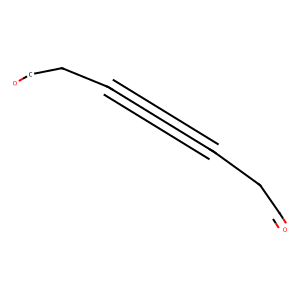

O=CCC#CCCO


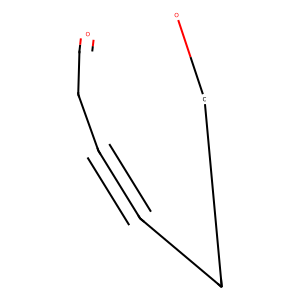

O=CCC#CCCO


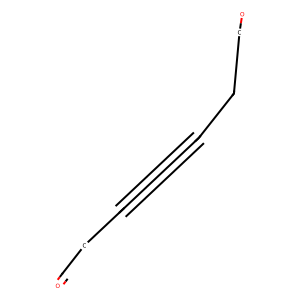

O=CCC#CCCO


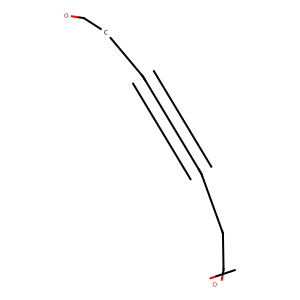

O=CCC#CCCO


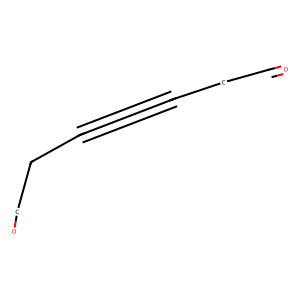

O=CCC#CCCO


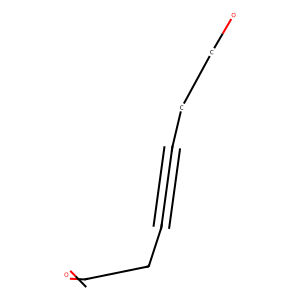

O=CCC#CCCO


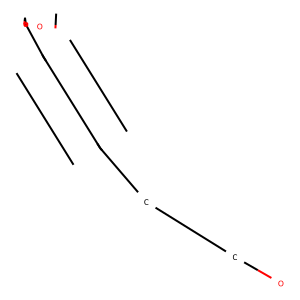

O=CCC#CCCO


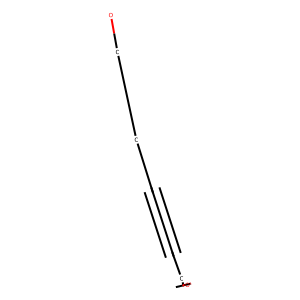

O=CCC#CCCO


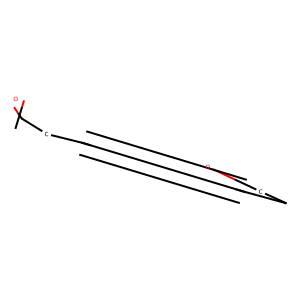

O=CCC#CCCO


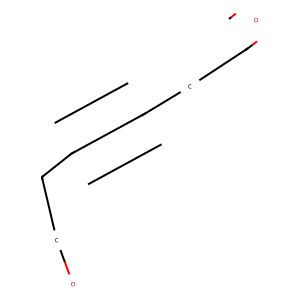

O=CCC#CCCO


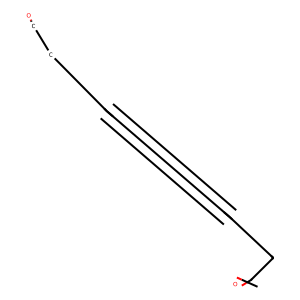

O=CCC#CCCO


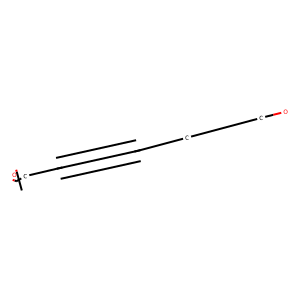

O=CCC#CCCO


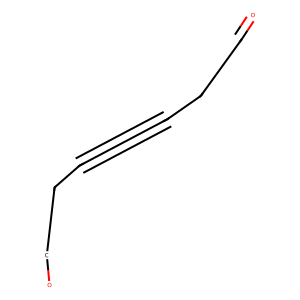

O=CCC#CCCO


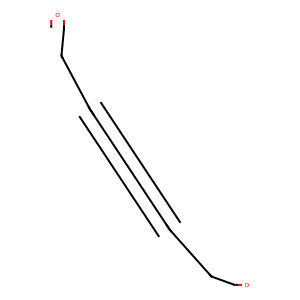

O=CCC#CCCO


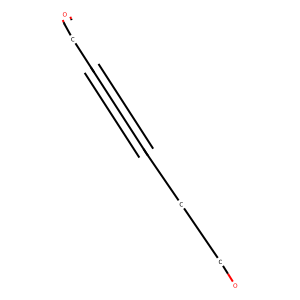

O=CCC#CCCO


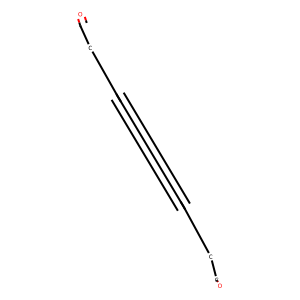

O=CCC#CCCO


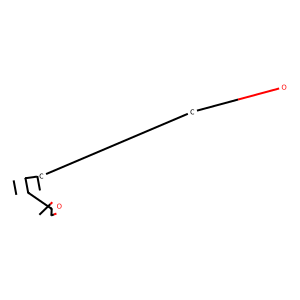

O=CCC#CCCO


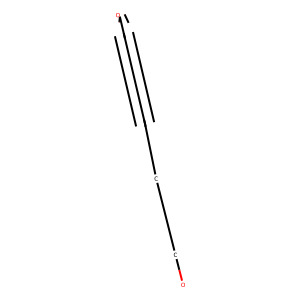

O=CCC#CCCO


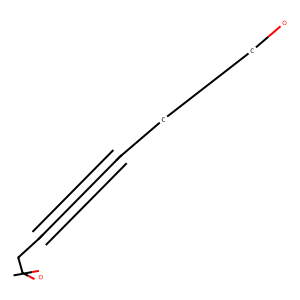

O=CCC#CCCO


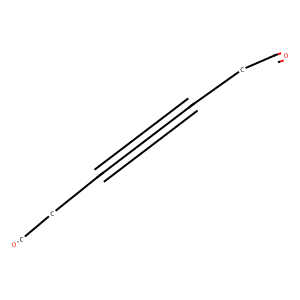

O=CCC#CCCO


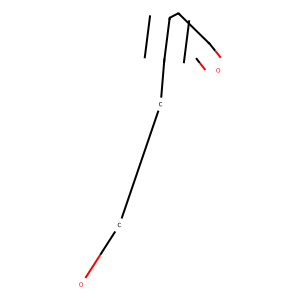

O=CCC#CCCO


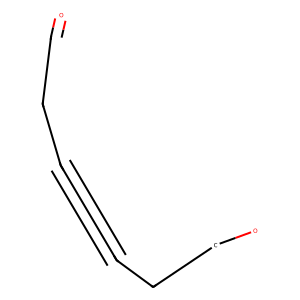

O=CCC#CCCO


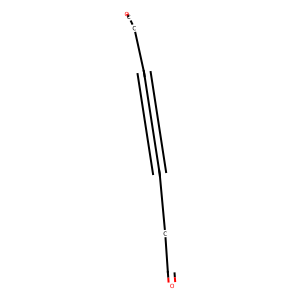

O=CCC#CCCO


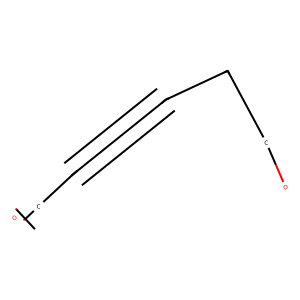

O=CCC#CCCO


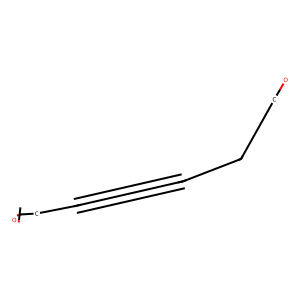

O=CCC#CCCO


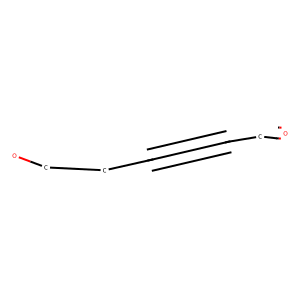

O=CCC#CCCO


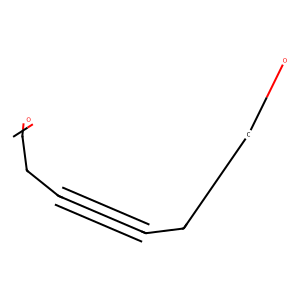

O=CCC#CCCO


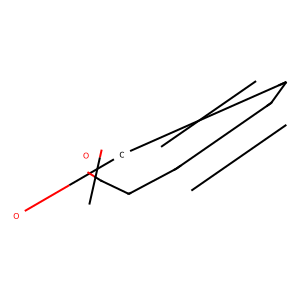

In [20]:
from copy import deepcopy
def set_rdmol_positions(rdkit_mol, pos):
    """
    Args:
        rdkit_mol:  An `rdkit.Chem.rdchem.Mol` object.
        pos: (N_atoms, 3)
    """
    mol = deepcopy(rdkit_mol)
    for i in range(pos.shape[0]):
        mol.GetConformer(0).SetAtomPosition(i, pos[i].tolist())
    return mol

# data = results[0]
data = results['results'][0]

real_gen = data['pos'].reshape(-1, data['rdmol'][0].GetNumAtoms(), 3)
test_gen = data['pos_gen'].reshape(-1, data['rdmol'][0].GetNumAtoms(), 3)
num_real_gen = real_gen.shape[0]
num_test_gen = test_gen.shape[0]

rmsd_confusion_mat = -1 * np.ones([num_real_gen, num_test_gen], dtype=float)

for i in range(num_test_gen) :
    gen_mol = set_rdmol_positions(data['rdmol'][i], test_gen[i])
    gen_mol_wo_H = Chem.RemoveHs(gen_mol)
    print(rdkit.Chem.MolToSmiles(gen_mol_wo_H))
    img = rdkit.Chem.Draw.MolToImage(gen_mol_wo_H, kekulize=False)
    display(img)

In [ ]:
import multiprocessing as mp
from functools import partial

def get_rmsd_confusion_matrix(data, useFF=False) :
    data['pos_gen'] = data['pos_gen'].reshape(-1, data['rdmol'].GetNumAtoms(), 3)

class CovMatEvaluator(object) :
    def __init__(self, num_workers=8, use_force_field=8,
                 thresholds=np.arange(0.05, 3.05, 0.05),
                 ratio=2, filter_disconnected = True):
        super().__init__()
        self.num_workers = num_workers
        self.use_force_field = use_force_field
        self.thresholds = np.array(thresholds).flatten()

        self.ratio = ratio
        self.filter_disconnected = filter_disconnected
        self.pool = mp.Pool(num_workers)

    def __call__(self, packed_data_list, start_idx=0) :
        func = partial(get_rmsd_confusion_matrix, useFF=self.use_force_field)



In [ ]:
pr('model.betas', model.betas, show_var=True)
pr('model.alphas', model.alphas[:500], show_var=True)
pr('model.sigmas', model.sigmas, show_var=True)
print(model.sigmas[4999], model.sigmas[2500], model.sigmas[1000], model.sigmas[500], model.sigmas[100], model.sigmas[0])
print(args.global_start_sigma)

====
model.betas.shape : torch.Size([5000])
model.betas : Parameter containing:
tensor([5.0450e-06, 5.0569e-06, 5.0687e-06,  ..., 1.9950e-03, 1.9950e-03,
        1.9951e-03])
====

====
model.alphas.shape : torch.Size([500])
model.alphas : tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999, 0.9999,
        0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998,
        0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998,
        0.9998, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997,
        0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997, 0.9997,
        0.9997, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996, 0.9996,
        0.9995, 0.9995, 0.9995, 0.9995, 

In [ ]:
# pr('edge_inv_global', edge_inv_global.view(-1), show_var=True)
# pr('edge_inv_local', edge_inv_local.view(-1), show_var=True)
# pr('edge_index', edge_index, show_var=True)
# pr('edge_type', edge_type, show_var=True)
# pr('edge_length', edge_length.view(-1), show_var=True)
# pr('local_edge_mask', local_edge_mask, show_var=True)



# global_mask, dist_tilde, local_edge_mask.unsqueeze(-1)
# global_mask, target_dist_global, edge_inv_global, x_score_global, pred_score_global, loss_global


pr('global_mask', global_mask, show_var=True) # (num_edges, 1)
pr('target_dist_global', target_dist_global, show_var=True) # (num_edges, 1)
pr('edge_inv_global', edge_inv_global, show_var=True) # (num_edges, 1)
pr('x_score_global', x_score_global, show_var=True) # (num_nodes, 3)
pr('pred_score_global', pred_score_global, show_var=True) #(num_nodes, 3)
pr('loss_global', loss_global, show_var=True) #(num_nodes, 1)

====
global_mask.shape : torch.Size([926, 1])
global_mask : tensor([[False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
     

In [ ]:
loss_global = (x_score_global - pred_score_global)**2 # (num_nodes, 3)
# loss_global = 2 * torch.sum(loss_global, dim=-1, keepdim=True)
pr('loss_global', loss_global, show_var=True)
loss_global = 2 * torch.sum(loss_global, dim=-1, keepdim=True)
pr('loss_global', loss_global, show_var=True)


====
loss_global.shape : torch.Size([44, 3])
loss_global : tensor([[8.0596e+01, 5.2742e+01, 1.4877e+00],
        [1.9917e+03, 3.0341e-02, 6.5116e-01],
        [6.7865e+02, 3.7781e+01, 1.3495e-02],
        [2.6614e+02, 5.4799e+01, 3.0940e+00],
        [4.3125e-01, 2.9894e-03, 1.2154e+00],
        [3.8284e+01, 5.2317e-03, 4.0306e-01],
        [8.1974e+01, 3.1268e-02, 1.6149e+00],
        [1.0671e+02, 1.5521e+00, 4.5824e+00],
        [1.3108e+01, 1.2484e+01, 2.7948e-01],
        [6.5722e+01, 9.0821e-01, 1.1343e+00],
        [2.3628e+01, 4.8280e+00, 3.0742e-06],
        [4.5696e+02, 7.5046e-02, 4.4838e+01],
        [5.7091e+02, 4.2352e+01, 4.9042e+01],
        [3.7053e+02, 3.6939e+01, 4.5952e+00],
        [2.6146e+00, 3.4884e+01, 6.5881e+00],
        [8.3629e+00, 5.3223e+00, 3.1195e+00],
        [7.5387e+02, 1.1918e+01, 2.5589e+00],
        [7.8419e+00, 3.6626e-02, 3.3359e-02],
        [4.5859e+02, 9.0919e+01, 2.5780e-01],
        [4.6889e+02, 1.4866e+01, 2.1862e+01],
        [1.1845e+02, 

In [ ]:
h_row, h_col = node_attr_global[edge_index[0]],node_attr_global[edge_index[1]]
# edge로 연결된 node 쌍의 attr을 곱해서, edge_attr과 이어붙임
h_pair = torch.cat([h_row*h_col, edge_attr_global], dim=-1)
pr('h_pair', h_pair, show_var=True)

====
h_pair.shape : torch.Size([342, 256])
h_pair : tensor([[-2.1867,  0.6717, -1.1077,  ...,  0.0485,  0.0080,  0.4564],
        [-1.4420,  2.3363, -0.9476,  ..., -0.2169, -0.0139, -0.3471],
        [-2.7073,  1.0182, -1.3287,  ..., -0.2509, -0.0234, -0.4007],
        ...,
        [ 0.4367,  2.0626,  1.0004,  ...,  0.2791, -0.0753, -0.9707],
        [ 0.6077,  2.2542,  0.7753,  ...,  0.2423, -0.0568, -0.8301],
        [ 0.4628,  2.2298,  1.0313,  ..., -0.2729,  0.0260, -0.2204]],
       grad_fn=<CatBackward0>)
====



In [ ]:
gg = GINEncoder(
    hidden_dim=args.hidden_dim,
    num_convs=args.num_convs_local,
)
local_edge_mask = edge_type > 0
pr('edge_index_local', edge_index[:, local_edge_mask], show_var=True)
pr('edge_attr_local', edge_attr_global, show_var=True)
pr('edge_attr_local[mask]', edge_attr_global[local_edge_mask], show_var=True)


====
edge_index_local.shape : torch.Size([2, 218])
edge_index_local : tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
          2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
         10, 10, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13, 13,
         13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15,
         16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18,
         18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20,
         20, 21, 21, 21, 21, 21, 21, 21

In [ ]:
# a = torch.Tensor([[1, 1,], [1, 1]])
# b = torch.Tensor([[2, 3,], [3, 4]])

# c = torch.cat([a, b], dim=1)
# c

tensor([[1., 1., 2., 3.],
        [1., 1., 3., 4.]])

In [ ]:
sigma_edge = torch.ones(size=(edge_index.size(1), 1), device=pos.device)

In [ ]:
edge_index.size(1)

420

In [ ]:
betas = get_sigmoid_beta_schedule(
    beta_start=beta_start,
    beta_end=beta_end,
    num_diffusion_timesteps=num_diffusion_timesteps,
)
alphas = (1. - betas).cumprod(dim=0)

betas = nn.Parameter(betas, requires_grad=False)
alphas = nn.Parameter(alphas, requires_grad=False)
num_timesteps = betas.size(0)

N = data.atom_type.size(0)
node2graph = data.batch

pr('betas', betas, show_var=True)
pr('alphas', alphas, show_var=True)

time_step = torch.randint(0, num_diffusion_timesteps, size=(data.num_graphs//2 + 1, ), device=data.pos.device)
time_step = torch.cat([time_step, num_diffusion_timesteps - time_step -1], dim=0)[:data.num_graphs]

a = alphas.index_select(0, time_step)

a_pos = a.index_select(0, node2graph).unsqueeze(-1)

pos_noise = torch.zeros(size=data.pos.size(), device=data.pos.device)
pos_noise.normal_()

pos_perturbed = data.pos + pos_noise * (1.0 - a_pos).sqrt() / a_pos.sqrt()

pr('time_step', time_step, show_var=True)
pr('a', a, show_var=True)
pr('a_pos', a_pos, show_var=True)
pr('pos_noise', pos_noise, show_var=False)
pr('pos_perturbed', pos_perturbed, show_var=False)


====
betas.shape : torch.Size([20])
betas : Parameter containing:
tensor([5.0450e-06, 9.3793e-06, 1.7479e-05, 3.2535e-05, 6.0238e-05, 1.1028e-04,
        1.9771e-04, 3.4197e-04, 5.5890e-04, 8.4346e-04, 1.1566e-03, 1.4412e-03,
        1.6581e-03, 1.8024e-03, 1.8898e-03, 1.9399e-03, 1.9676e-03, 1.9826e-03,
        1.9907e-03, 1.9951e-03])
====

====
alphas.shape : torch.Size([20])
alphas : Parameter containing:
tensor([1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9998, 0.9996, 0.9992, 0.9987,
        0.9978, 0.9967, 0.9952, 0.9936, 0.9918, 0.9899, 0.9880, 0.9861, 0.9841,
        0.9821, 0.9802])
====

====
time_step.shape : torch.Size([1])
time_step : tensor([8])
====

====
a.shape : torch.Size([1])
a : tensor([0.9987])
====

====
a_pos.shape : torch.Size([20, 1])
a_pos : tensor([[0.9987],
        [0.9987],
        [0.9987],
        [0.9987],
        [0.9987],
        [0.9987],
        [0.9987],
        [0.9987],
        [0.9987],
        [0.9987],
        [0.9987],
        [0.9987],
      

In [ ]:
def get_adj_order_for_graph(adj_order, data, idx):
    # idx번째 그래프의 노드 범위 추출
    node_start = data.ptr[idx].item()
    node_end = data.ptr[idx + 1].item()

    # 해당 범위를 사용하여 adj_order에서 그래프 부분만 슬라이싱
    return adj_order[node_start:node_end, node_start:node_end]

adj_order_1 = get_adj_order_for_graph(adj_order, data, 0)

# 두 번째 데이터의 adj_order 추출
adj_order_2 = get_adj_order_for_graph(adj_order, data, 1)

pr('adj_order_1', adj_order_1, show_var=True)
pr('adj_order_2', adj_order_2, show_var=True)

====
adj_order_1.shape : torch.Size([21, 21])
adj_order_1 : tensor([[0., 1., 1., 1., 2., 3., 4., 3., 3., 2., 2., 3., 4., 5., 6., 7., 6., 6.,
         3., 3., 1.],
        [1., 0., 2., 2., 3., 4., 5., 4., 4., 3., 3., 4., 5., 6., 7., 8., 7., 7.,
         4., 4., 2.],
        [1., 2., 0., 2., 3., 4., 5., 4., 4., 3., 3., 4., 5., 6., 7., 8., 7., 7.,
         4., 4., 2.],
        [1., 2., 2., 0., 1., 2., 3., 2., 2., 1., 1., 2., 3., 4., 5., 6., 5., 5.,
         2., 2., 2.],
        [2., 3., 3., 1., 0., 1., 2., 1., 1., 2., 2., 3., 4., 5., 6., 7., 6., 6.,
         3., 3., 3.],
        [3., 4., 4., 2., 1., 0., 1., 2., 2., 3., 3., 4., 5., 6., 7., 8., 7., 7.,
         4., 4., 4.],
        [4., 5., 5., 3., 2., 1., 0., 3., 3., 4., 4., 5., 6., 7., 8., 9., 8., 8.,
         5., 5., 5.],
        [3., 4., 4., 2., 1., 2., 3., 0., 2., 3., 3., 4., 5., 6., 7., 8., 7., 7.,
         4., 4., 4.],
        [3., 4., 4., 2., 1., 2., 3., 2., 0., 3., 3., 4., 5., 6., 7., 8., 7., 7.,
         4., 4., 4.],
        [2., 

In [ ]:
class testModel(nn.Module) :
    def __init__(self) :
        super().__init__()

        self.one = 1
        self.two = 2
        self.three = 3


    def forward(self, x) :
        print(self.one, self.two, self.three, x)


    def get_loss(self,x) :
        self(
            x=10
        )
        # self.forward(x)


tm = testModel()
# tm(5)
tm.get_loss(5)

1 2 3 10


In [ ]:
# target_dist_global, pos_tilde, edge_index, edge_length

N = pos_tilde.size(0)
print(N)

dd_dr = (1. / edge_length) * (pos[edge_index[0]] - pos[edge_index[1]])
pr('dd_dr', dd_dr, show_var=True)
pr('target_dist_global', target_dist_global)
scatter_a = scatter_add(dd_dr * target_dist_global, edge_index[0], dim=0, dim_size=N)
pr('scatter_a', scatter_a, show_var=True)

45
====
dd_dr.shape : torch.Size([972, 3])
dd_dr : tensor([[ 0.5593,  1.0407, -0.0096],
        [ 0.8610,  0.4884,  0.1638],
        [ 0.7209,  0.6893,  0.0780],
        ...,
        [-0.5119, -0.9042,  0.0968],
        [ 0.4457,  0.1804, -0.9279],
        [ 0.8439, -0.4536, -0.2388]])
====

====
target_dist_global.shape : torch.Size([972, 1])

====

====
scatter_a.shape : torch.Size([45, 3])
scatter_a : tensor([[-2.9459e+00,  9.0996e-01, -7.4518e-02],
        [ 3.1159e+00, -1.9717e+00, -3.7941e-01],
        [-1.8092e-02, -7.5263e-01,  4.6887e-01],
        [-1.3880e+00, -1.0933e+00,  5.8232e-01],
        [-3.3431e-01, -2.4253e+00, -4.3305e-01],
        [ 2.4292e+00,  9.8057e-01, -3.2119e-01],
        [ 1.0335e+01,  7.4259e-02, -2.5895e+00],
        [ 5.9414e+00, -8.6011e-01,  9.8240e-01],
        [ 6.3499e+00, -4.5949e+00, -1.1991e+00],
        [-1.9468e+00,  3.5359e+00, -2.3599e-02],
        [-1.3835e+01,  7.5942e+00, -1.7680e+00],
        [-5.3945e+00,  2.2510e+00,  1.2644e+00],
    